# Test data preparation methodology

Todo:
- [x] standardize location covariates
- [x] look at climatologies of the resulting residuals
- [x] average over each dimension (x-axis is other dim, avg value on y-axis) for each month and each variable
- [x] qqplot to test Gaussianity (each field, each month)
- [x] mircro-lag adjust
- [ ] composite WLS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import spatial_tools
import fields
import variogram as vgm
import cov_model
import plot

In [4]:
# Get data: 5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_4x5deg_monthly_conus_augmented.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

var_names = ["xco2", "sif"]
cross_name = "xco2:sif"

## Overview analysis

In [5]:
# TBH we could just compute the mean upon preprocessing and simplify some of this... but it might be useful code to have in the future
def full_preprocess(ds):
    return xr.concat([fields.preprocess_ds(ds, t) for t in ds.time], dim="time")

def combined_climatologies(da1, da2):
    df1 = da1.mean(dim=["lon", "lat"]).to_dataframe().reset_index()
    df2 = da2.mean(dim=["lon", "lat"]).to_dataframe().reset_index()
    return pd.merge(df1, df2, on=["time"], how="outer")

In [6]:
# Construct preprocessed xco2 and sif datasets
ds_xco2_prep = full_preprocess(ds_xco2)
ds_sif_prep = full_preprocess(ds_sif)

# Monthly climatologies of residuals
df_monthly = combined_climatologies(ds_xco2_prep.xco2, ds_sif_prep.sif)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


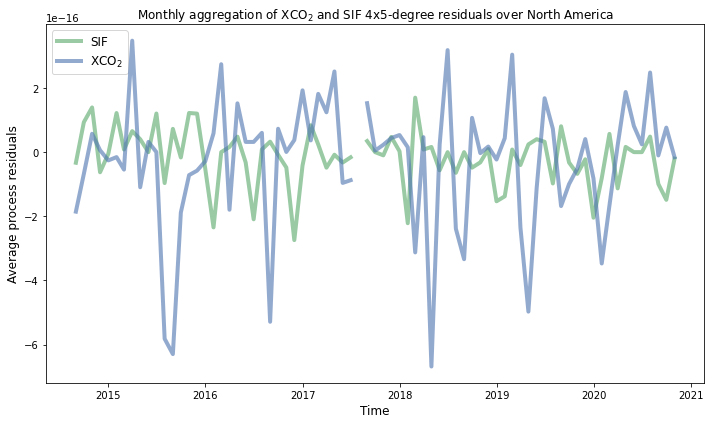

In [7]:
# Plot regional monthly climatology
title = "Monthly aggregation of XCO$_2$ and SIF 4x5-degree residuals over North America"
fname = "climatologies_conus_residuals_sd_nofilter"
plot.resid_climatology(df_monthly, title, fname)

## Targeted analysis

In [5]:
# Analysis variables
month = 7
timedelta = -1
n_bins = 60
fast_dist = True

timestamps = np.array(ds.time[ds.time.dt.month == month].values, dtype="datetime64[D]")

In [6]:
def variography_analysis(timestamp):
    mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, fast_dist=fast_dist)
    if mf.field_1.values.size == 0:
        return None
    vario_res, covario_res, _ = vgm.variogram_analysis(mf, None, n_bins=n_bins)

    lags = vario_res["xco2"]["bin_center"].values
    bin_width = lags[2] - lags[1]
    
#     # Plot maps
#     fname = f"4x5degree_residuals_{timestamp}_mad"
#     plot.plot_fields(mf, coord_avg=True, filename=fname)
    
    # Q-Q plots
    plot.qq_plots(mf)
    
    # Plot variograms
    semi_name = f"semivariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag_mad"
    plot.plot_semivariograms(vario_res, timestamp, timedelta) #, filename=semi_name
    cov_name = f"covariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag_mad"
    plot.plot_covariograms(covario_res, timestamp, timedelta) #, filename=cov_name

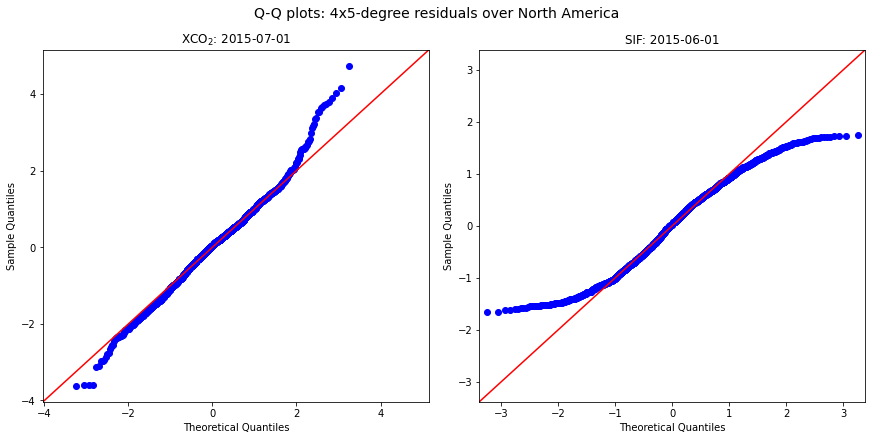

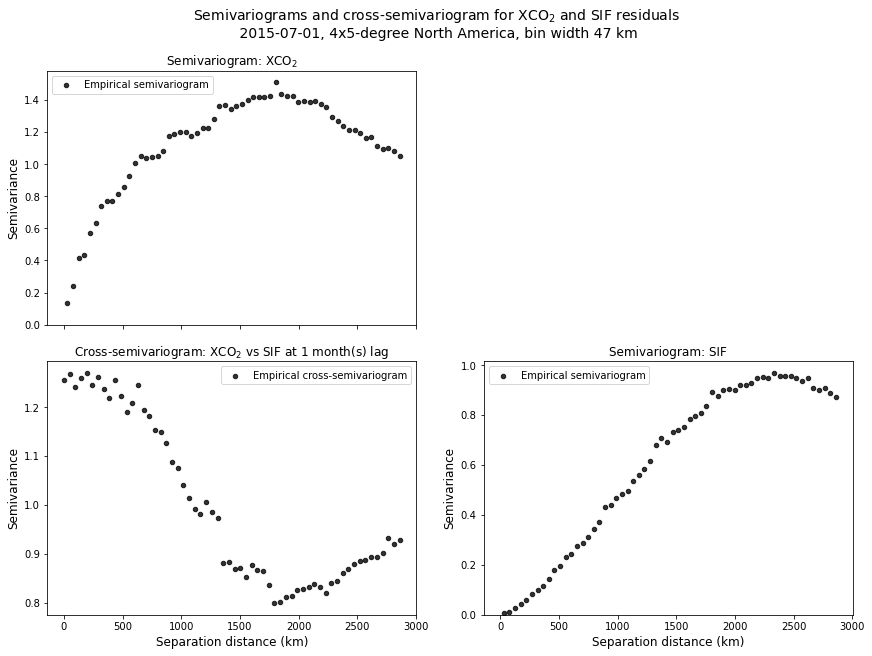

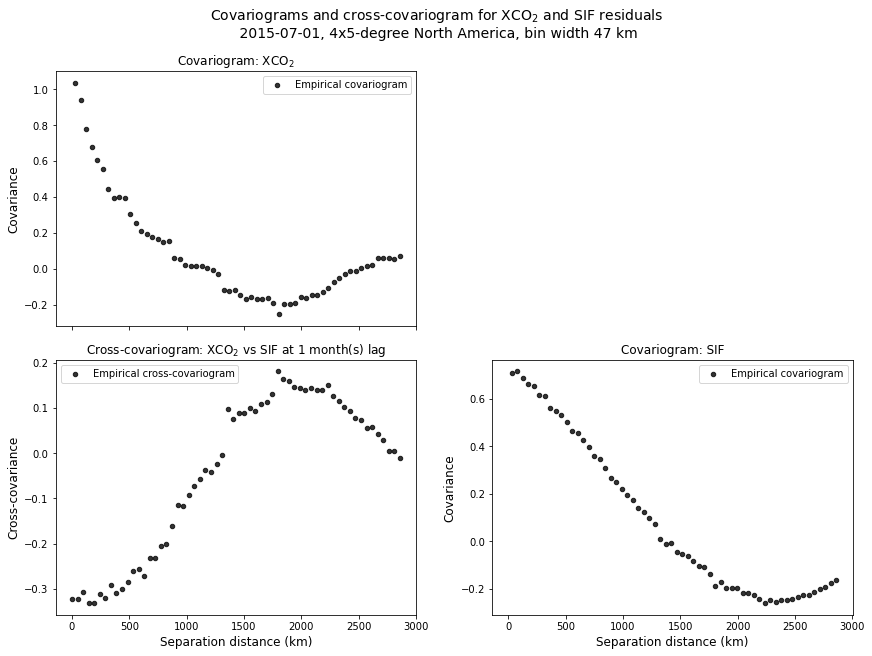

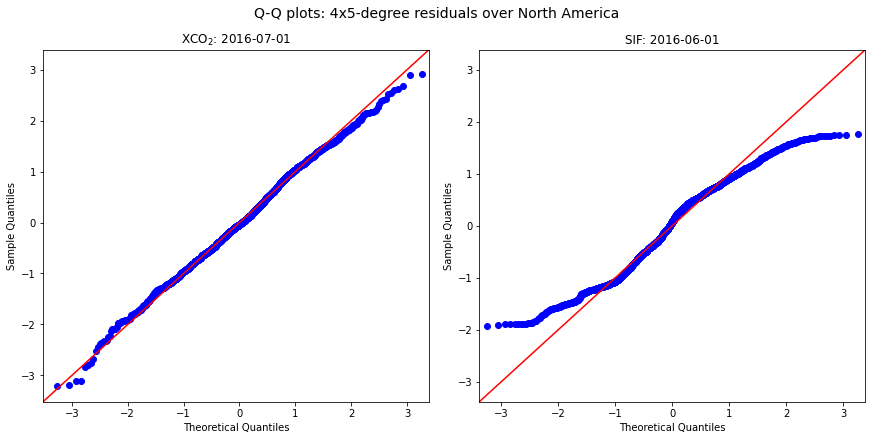

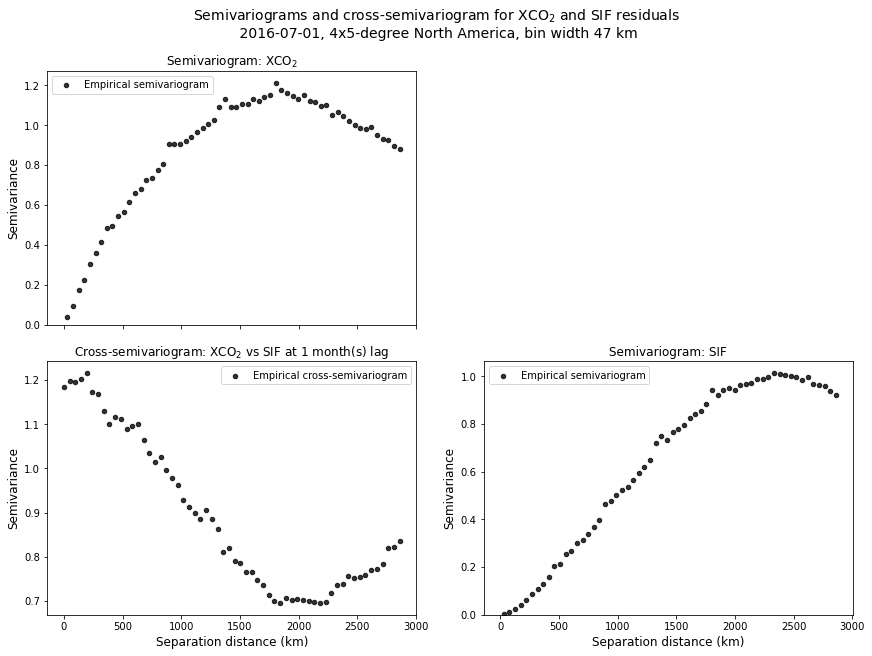

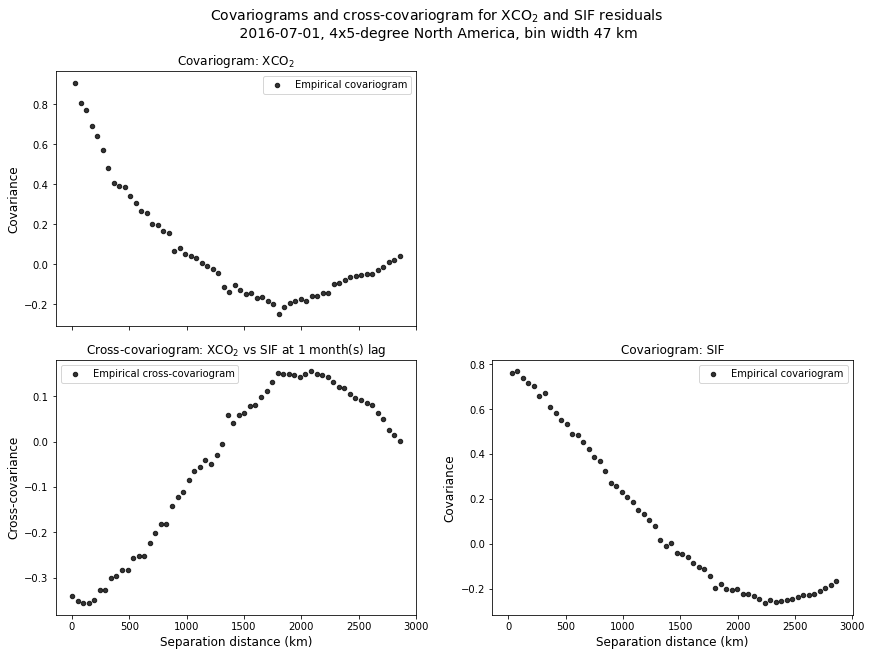

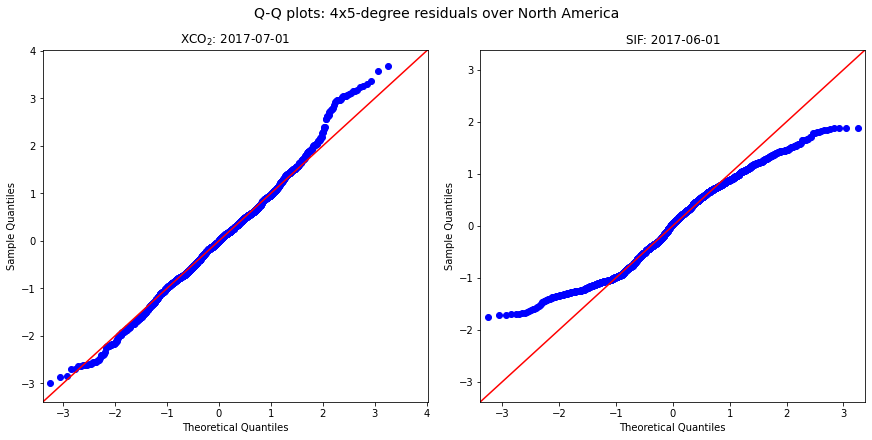

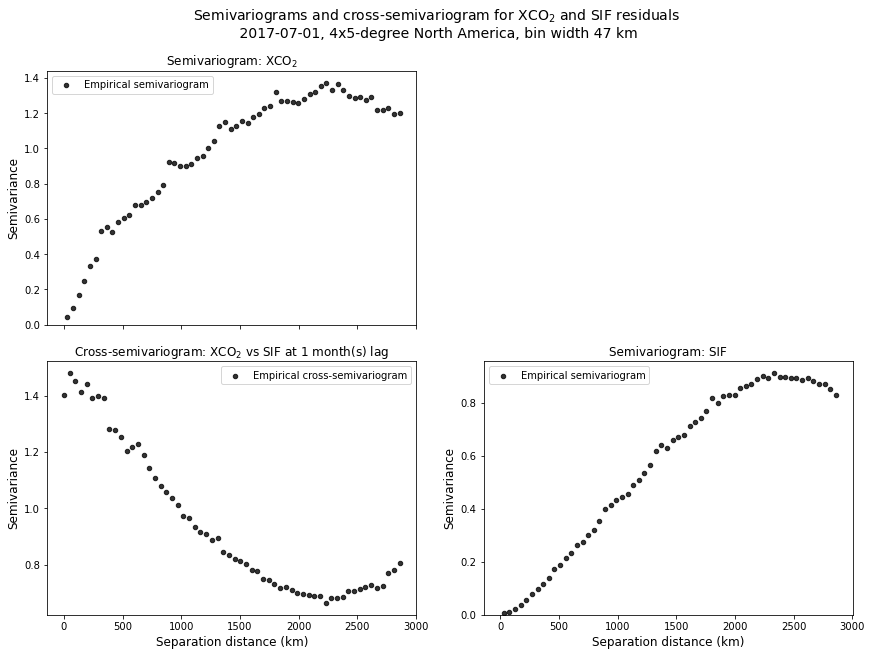

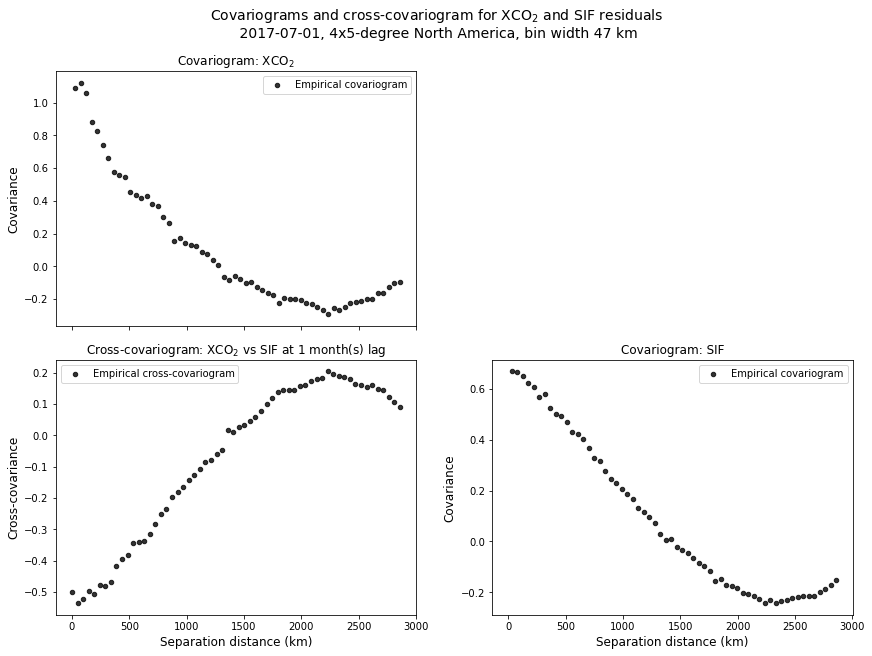

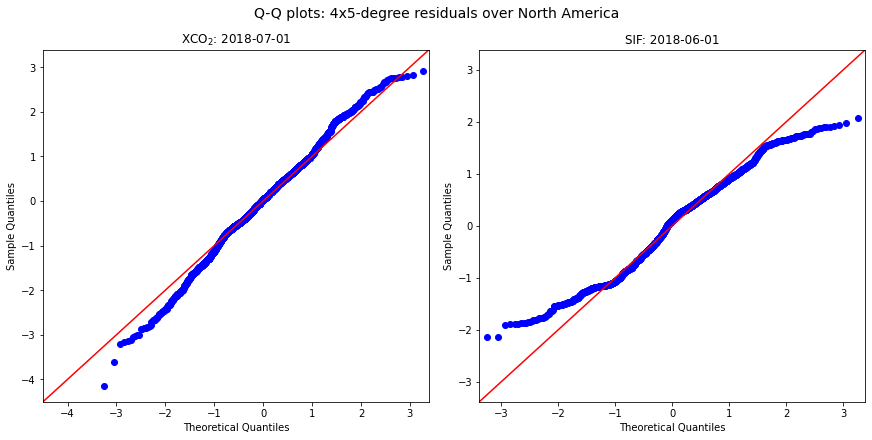

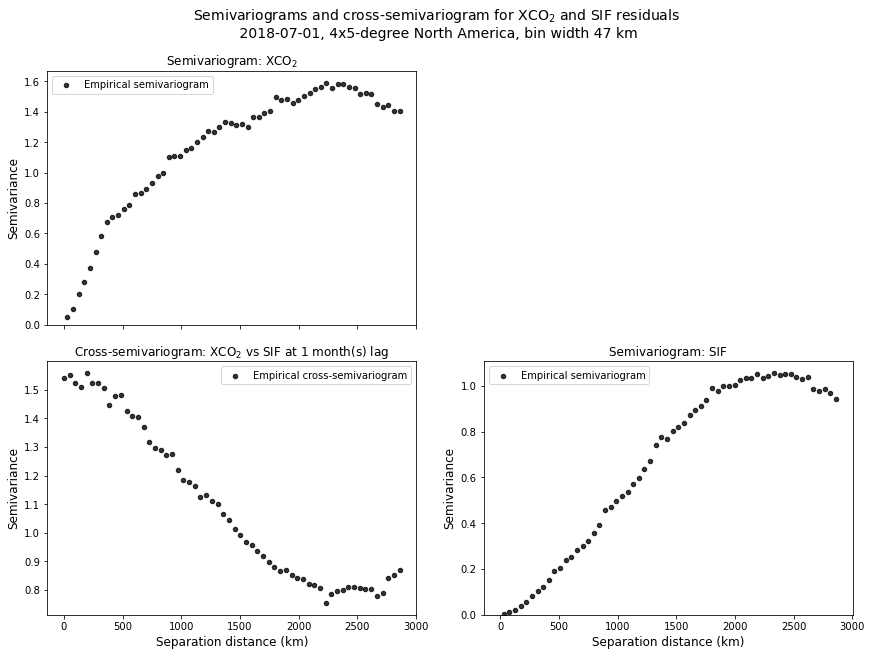

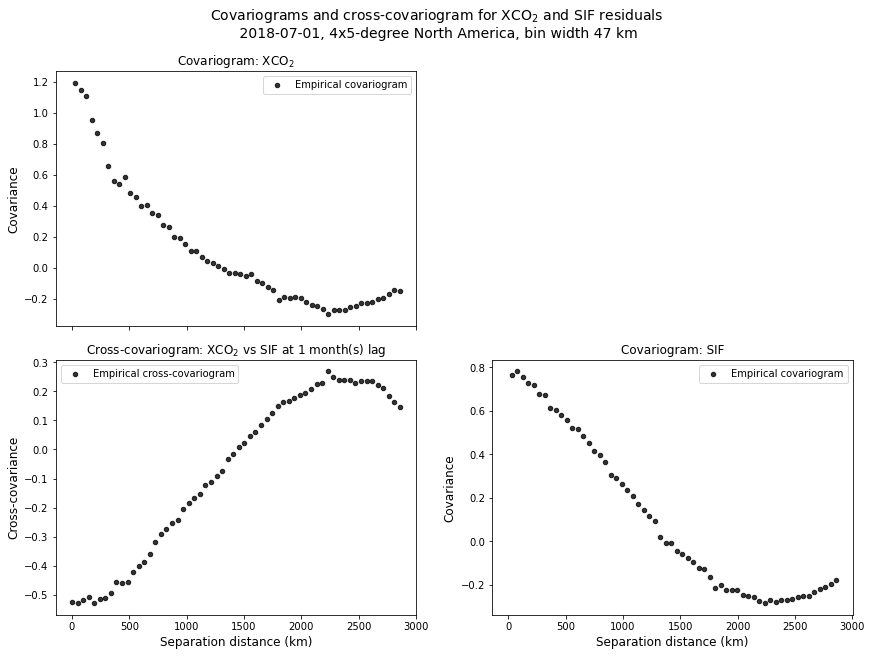

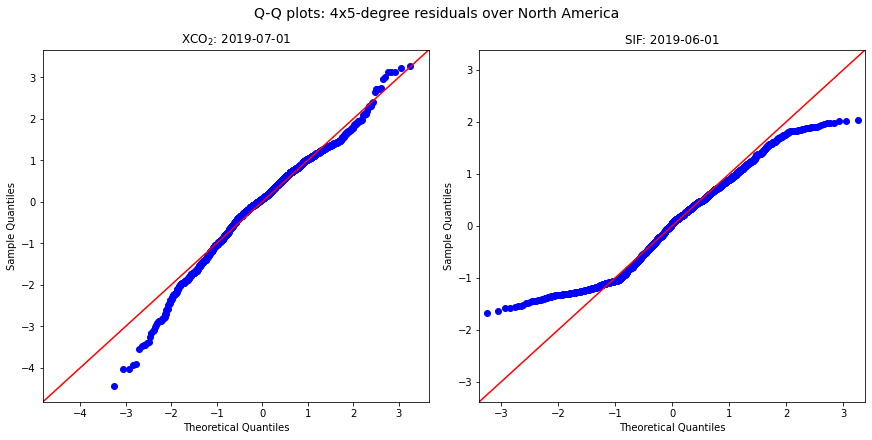

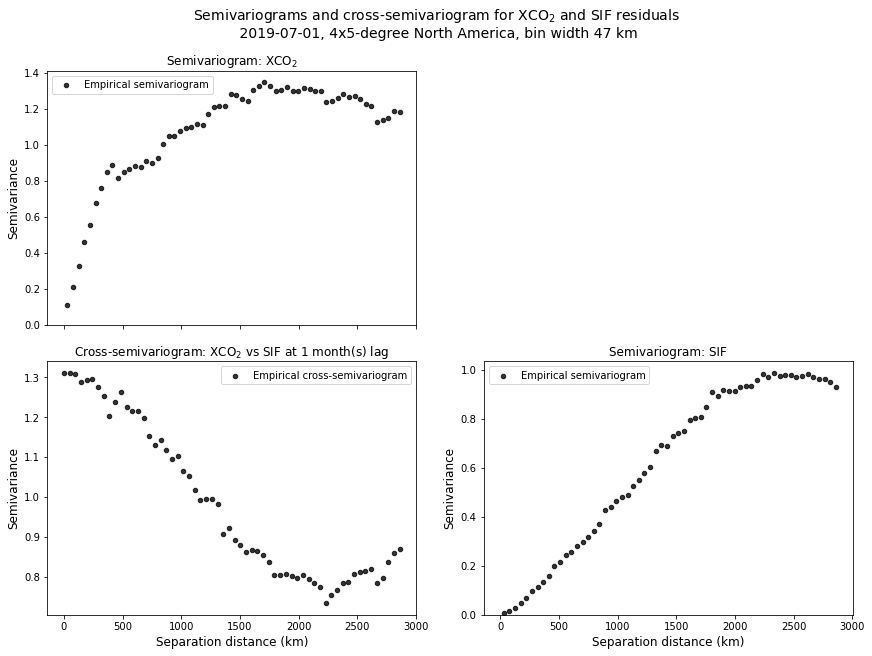

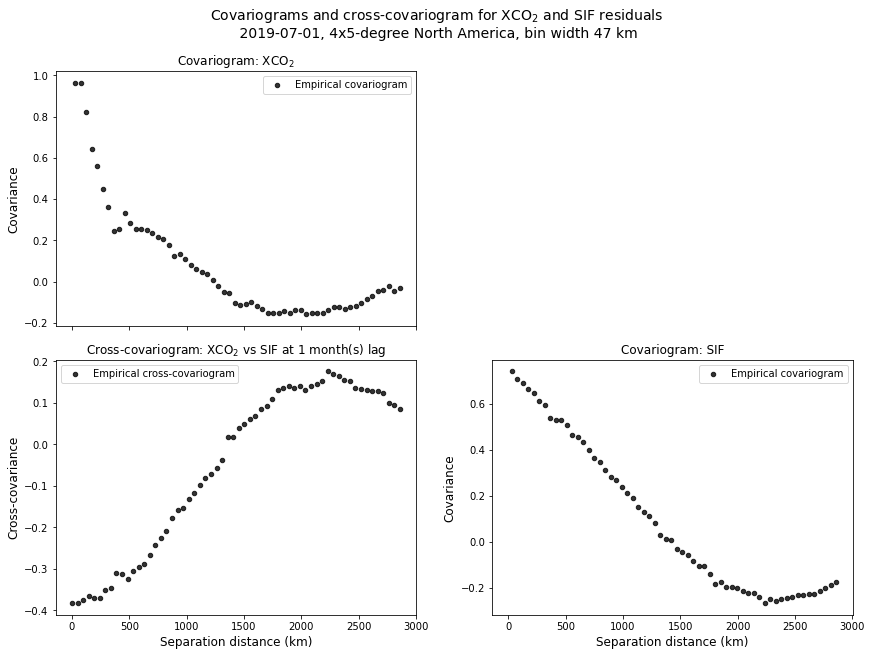

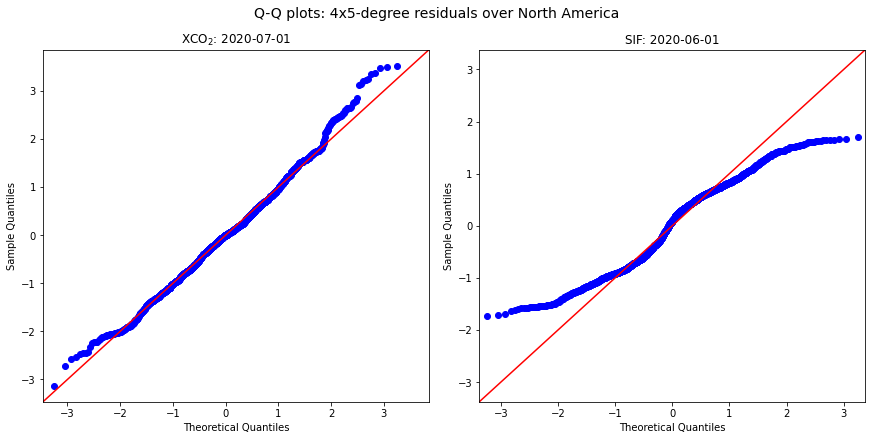

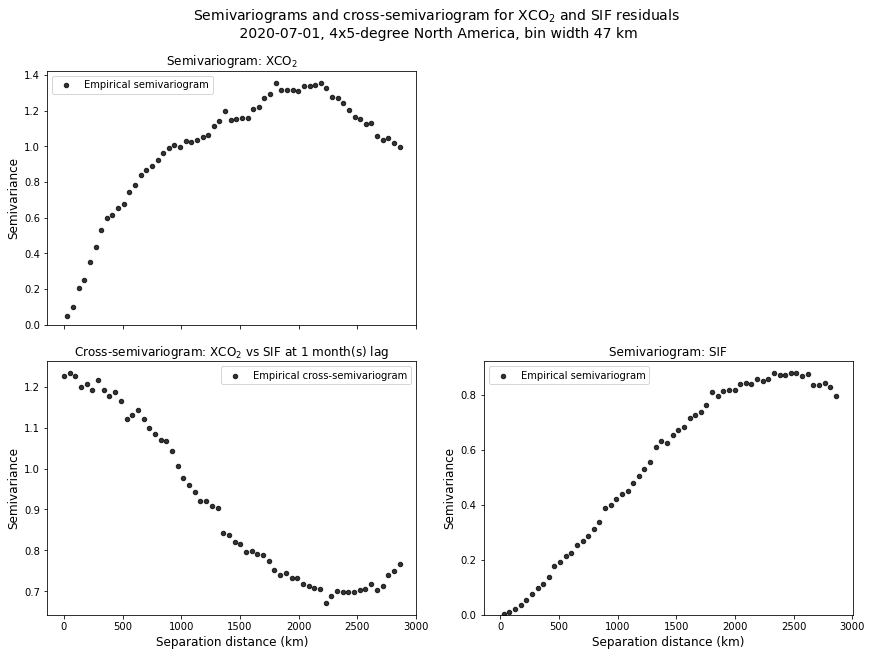

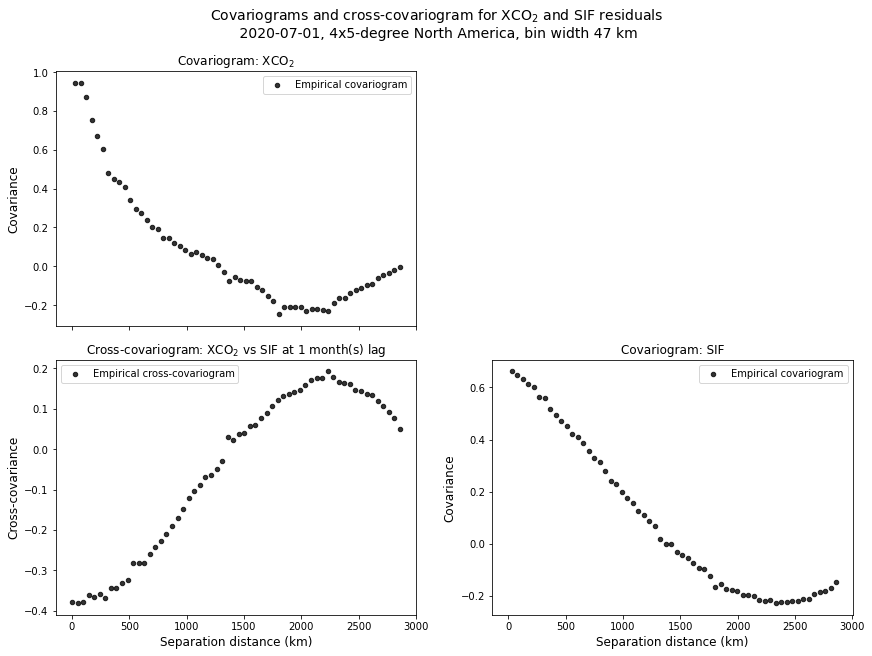

In [8]:
[variography_analysis(t) for t in timestamps];